In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter, OrderedDict
import re

#NLTK RELATED
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.corpus import stopwords

#MODELS
from sklearn.feature_extraction.text import *
from sklearn.naive_bayes import *
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import *
from sklearn.svm import *
from sklearn.neural_network import *
from sklearn.ensemble import * 
from sklearn.model_selection import *

#### Data Import

In [2]:
SENT_DATA = pd.read_csv('sent.txt', sep='\t', header=None, names=['sent_value','word'])

In [3]:
SENT_DICT = SENT_DATA.set_index('word').to_dict()['sent_value']

In [4]:
SENT_DF = pd.DataFrame(columns=['label','tweet'])

In [5]:
for w, s in SENT_DICT.items():
    if s > 0.5:
        SENT_DF = SENT_DF.append(pd.Series(['positive'," ".join(w for i in range(100))], index=['label','tweet']), 
                                 ignore_index=True)
    elif s <= 0.5:
        SENT_DF = SENT_DF.append(pd.Series(['negative'," ".join(w for i in range(100))], index=['label','tweet'])
                                           , ignore_index=True)

In [6]:
TRAIN_DATA = pd.read_csv('./Data/train.tsv', sep='\t', header=None, names=['label','tweet'])
DEV_DATA = pd.read_csv('./Data/dev.tsv', sep='\t', header=None, names=['label','tweet'])

#### Feature Pre-processing 

In [7]:
group_re = re.compile(r'''
                         \d+[:\.]\d+
                         |(https?://)?(\w+\.)(\w{2,})+([\w/]+)
                         |[@\#]?\w+(?:[-']\w+)*
                         |[^a-zA-Z0-9 ]+''',
                         re.VERBOSE)

In [8]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
def remove_digits(input_text):
    return re.sub('\d+', '', input_text)

In [10]:
def remove_stopwords(lst):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["not", "no"] 
    clean_words = [word for word in lst if (word not in stopwords_list or word in whitelist)]
    return clean_words

#### Tokenization

In [11]:
def grouping(text):
    return [ m.group() for m in group_re.finditer(text) ]

#### Lemmatization and Stemming

In [12]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

#### POS Tagged stopword removal

In [13]:
STOP_TYPES = ['ADP','PRT','PRON','VERB','.', 'CONJ', 'X', 'NUM']

#### Regex for Emoticons, Punctuation and Hashtags

In [14]:
# Hashtags
hash_regex = re.compile(r"#(\w+)")
def hash_repl(match):
    return '__HASH_'+match.group(1).upper()

# Handles
hndl_regex = re.compile(r"@(\w+)")
def hndl_repl(match):
    return '__HNDL_'+match.group(1).upper()

# URLs
url_regex = re.compile(r"(http|https|ftp)://[a-zA-Z0-9\./]+")

# Spliting by word boundaries
word_bound_regex = re.compile(r"\W+")

# Repeating words like hurrrryyyyyy
rpt_regex = re.compile(r"(.)\1{1,}", re.IGNORECASE);
def rpt_repl(match):
    return match.group(1)+match.group(1)

# Emoticons
emoticons = \
    [   ('__EMOT_SMILEY', [':-)', ':)', '(:', '(-:', ] ) ,\
        ('__EMOT_LAUGH', [':-D', ':D', 'X-D', 'XD', 'xD', ] ),\
        ('__EMOT_LOVE', ['<3', ':\*', ] ),\
        ('__EMOT_WINK', [';-)', ';)', ';-D', ';D', '(;', '(-;', ] ),\
        ('__EMOT_FROWN', [':-(', ':(', '(:', '(-:', ] ),\
        ('__EMOT_CRY', [':,(', ':\'(', ':"(', ':(('] ) ,\
    ]

    
#For emoticon regexes
def escape_paren(arr):
    return [text.replace(')', '[)}\]]').replace('(', '[({\[]') for text in arr]

def regex_union(arr):
    return '(' + '|'.join( arr ) + ')'

emoticons_regex = [ (repl, re.compile(regex_union(escape_paren(regx))) ) \
                    for (repl, regx) in emoticons ]
    
# Punctuations
punctuations = \
    [   #('', ['.', ] ),\
        #('', [',', ] ),\
        #('', ['\'', '\"', ] ),\
        ('__PUNC_EXCL', ['!', '¡', ] ) ,\
        ('__PUNC_QUES', ['?', '¿', ] ) ,\
        ('__PUNC_ELLP', ['...', '…', ] ) ,\
    ]

    
    #For punctuation replacement
def punctuations_repl(match):
    text = match.group(0)
    repl = []
    for (key, parr) in punctuations :
        for punc in parr :
            if punc in text:
                repl.append(key)
    if( len(repl)>0 ) :
        return ' '+' '.join(repl)+' '
    else :
        return ' '


In [15]:
def processHashtags( text, subject='', query=[]):
    return re.sub( hash_regex, hash_repl, text)

def processHandles( text, subject='', query=[]):
    return re.sub( hndl_regex, hndl_repl, text)

def processUrls( text, subject='', query=[]):
    return re.sub( url_regex, ' __URL ', text)

def processEmoticons( text, subject='', query=[]):
    for (repl, regx) in emoticons_regex :
        text = re.sub(regx, ' '+repl+' ', text)
    return text

def processPunctuations( text, subject='', query=[]):
    return re.sub( word_bound_regex , punctuations_repl, text)

In [16]:
def preprocess(pd_df):
    '''Pre-process data according to steps above. Requires data to be stored in Pandas Dataframe'''
    #Remove contractions
    pd_df = pd_df.apply(decontracted)
    #Remove digits
    pd_df = pd_df.apply(remove_digits)
    #Remove hashtags
    pd_df = pd_df.apply(processHashtags)
    #Convert Handles
    pd_df = pd_df.apply(processHandles)
    #Convert Emoticons
    pd_df = pd_df.apply(processEmoticons)
    #Convert URLs
    pd_df = pd_df.apply(processUrls)
    #Convert punctuation
    pd_df = pd_df.apply(processPunctuations)
    #Tokenize
    pd_df = pd_df.apply(grouping)
    #Remove stopwords
    pd_df = pd_df.apply(remove_stopwords)
    #Lemmatize
    pd_df = pd_df.apply(lambda x: [lemmatizer.lemmatize(y.lower(), 'v') for y in x])
    #Stopword removal
    pd_df = pd_df.apply(lambda x: [w for w in x if nltk.pos_tag(w)[0][1] not in STOP_TYPES])
    return [' '.join(x for x in pd_df.values[i]) for i in range(len(pd_df))]

In [17]:
COMBINED_DF = pd.concat([TRAIN_DATA, SENT_DF])

In [18]:
TRAIN_DF = preprocess(TRAIN_DATA['tweet'])

#### Class Priors (for NB model)

In [19]:
pos_df = TRAIN_DATA[TRAIN_DATA['label']=='positive']
neg_df = TRAIN_DATA[TRAIN_DATA['label']=='negative']
neu_df = TRAIN_DATA[TRAIN_DATA['label']=='neutral']

In [20]:
print("Positive: " + str(len(pos_df)/(len(pos_df)+len(neg_df)+len(neu_df))*100) + "%")
print("Negative: " + str(len(neg_df)/(len(pos_df)+len(neg_df)+len(neu_df))*100) + "%")
print("Neutral: " + str(len(neu_df)/(len(pos_df)+len(neg_df)+len(neu_df))*100) + "%")

Positive: 37.61737753139495%
Negative: 14.854621563525287%
Neutral: 47.52800090507976%


In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import *
from sklearn.metrics import *

In [22]:
X_TRAIN = TRAIN_DF
y_TRAIN = TRAIN_DATA['label'].values

In [23]:
models = [LogisticRegression(), LinearSVC(C=1.0, loss='hinge',
                                         max_iter=10, penalty='l2'), 
          MultinomialNB(class_prior=(0.15, 0.47, 0.38)), Perceptron(max_iter=1000), 
          MLPClassifier(max_iter=1000),
          RandomForestClassifier(), 
          GradientBoostingClassifier(), DummyClassifier(strategy='most_frequent')]

In [24]:
def pipeline_run(model, train_df, train_y, dev_df, dev_labels, k):
    p = make_pipeline(
           TfidfVectorizer(strip_accents='unicode',tokenizer=grouping, 
                           ngram_range=(1,2), min_df=20, norm='l2'),
            SelectKBest(k=k),
            model)
    p.fit(train_df, train_y)
    pred = p.predict(dev_df)
    return accuracy_score(dev_labels, pred)

In [26]:
DEV_DF = preprocess(DEV_DATA['tweet']) 

In [28]:
def k_grid(n, train_df, train_y):
    params = {'min_df': range(n), 'norm':['l1','l2']}
    tfidf_vec = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(train_df)
    clf = GridSearchCV(tfidf_vec, params)
    clf.fit(tfidf_matrix, train_y)
    return clf.best_estimator_
    

In [29]:
pipelines = [make_pipeline(
           TfidfVectorizer(strip_accents='unicode',tokenizer=grouping, 
                           ngram_range=(1,2), min_df=20, max_df=0.5, norm='l2'),
            SelectKBest(k=500),
            model) for model in models]

In [30]:
model_names = [list(i.named_steps.keys())[2] for i in pipelines]

In [31]:
fitted = [i.fit(X_TRAIN, y_TRAIN) for i in pipelines]

In [32]:
params = {'C': [0.0001, 0.001, 0.01, 0.1, 1.0],
 'loss': ['hinge', 'squared_hinge'],
 'max_iter': [10, 100, 1000, 2000],
 'multi_class': ['ovr', 'crammer_singer']}

#### Gridsearch

In [34]:
svc = LinearSVC()
clf = GridSearchCV(svc, params)
tfidf = TfidfVectorizer(strip_accents='unicode',tokenizer=grouping, 
                           ngram_range=(1,2), min_df=20, norm='l2')
tfidf_matrix = tfidf.fit_transform(TRAIN_DF)
clf.fit(tfidf_matrix, y_TRAIN)

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1.0], 'loss': ['hinge', 'squared_hinge'], 'max_iter': [10, 100, 1000, 2000], 'multi_class': ['ovr', 'crammer_singer']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [35]:
clf.best_estimator_

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=100, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

#### Feature importance in models

In [36]:
for fname, weight in sorted( zip(fitted[2].named_steps['multinomialnb'].coef_.ravel(), 
                                 fitted[2].named_steps['tfidfvectorizer'].get_feature_names()) ,reverse=True)[:20]:
    print(fname, weight)

-3.130834475372188 wait
-3.4726737678906145 knicks vs
-3.476757246936203 conference
-3.5081453975381764 excite
-3.716353798262878 joke
-3.83666283242849 part
-3.90833889575831 july
-3.9420108152578566 knicks
-4.0544149968010466 oct
-4.061491889421642 joseph
-4.1342063329904715 they
-4.135485933119972 __emot_wink
-4.144153553655327 __punc_excl the
-4.211286866561512 central
-4.25691510844084 __punc_ellp i
-4.258841129961904 dude
-4.314771976624252 vs
-4.319024580655106 wednesday
-4.389435246405659 vita
-4.442904368807706 report


In [37]:
for fname, weight in sorted( zip(fitted[1].named_steps['linearsvc'].coef_.ravel(), 
                                 fitted[1].named_steps['tfidfvectorizer'].get_feature_names()) ,reverse=True)[:20]:
    print(fname, weight)

5.798950769438543 vita
5.074114883024295 years
4.875811163809757 _
4.314720486531113 white
4.267395828381918 care
4.200946076001744 wow
4.063057728163819 vote
3.7492347977789175 gonna
3.408108246273362 hate
3.3920875436678677 yes
3.296516212333016 yay
2.9533366708156996 here
2.8743039058863973 fact
2.8073974042818417 austin
2.6712895821965335 anderson
2.518929578493452 club
2.4954160138917336 yet
2.340882833090978 visit
2.3351503357745536 halloween
2.2893856340854417 face


In [38]:
for fname, weight in sorted(zip(fitted[5].named_steps['randomforestclassifier'].feature_importances_, 
                                 fitted[5].named_steps['tfidfvectorizer'].get_feature_names()), reverse=True)[:10]:
    print(fname, weight)

0.047144299190170394 __punc_ellp i
0.02529942706733778 excite
0.023636732497281186 __punc_excl we
0.023089244335262996 ceo
0.01916243538186348 conference
0.016467582992154322 __emot_laugh
0.014940754960445673 dont
0.014289445567542686 __emot_wink
0.013875503406133416 __punc_excl the
0.013326085609557415 check


In [39]:
for fname, weight in sorted(zip(fitted[6].named_steps['gradientboostingclassifier'].feature_importances_, 
                                 fitted[6].named_steps['tfidfvectorizer'].get_feature_names()), reverse=True)[:10]:
    print(fname, weight)

0.04975988411684112 excite
0.042677703381100086 __punc_ellp i
0.027402543580717423 ceo
0.022161468390823526 dont
0.02166386822629843 check
0.02096656640138674 answer
0.020779573720986853 __emot_laugh
0.02036626989834181 class
0.019442059412274608 brooklyn
0.018595254963632825 __punc_excl we


In [40]:
importances = fitted[6].named_steps['gradientboostingclassifier'].feature_importances_
indices = np.argsort(importances)[::-1]

Text(0.5,0,'Relative Importance')

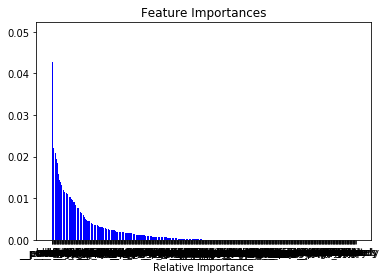

In [41]:
plt.figure(1)
plt.title('Feature Importances')
plt.bar(range(len(indices)), importances[indices], color='b', align='center')
plt.xticks(range(len(indices)), np.array(fitted[6].named_steps['tfidfvectorizer'].get_feature_names())[indices])
plt.xlabel('Relative Importance')

#### Evaluate Validation Set

In [42]:
import operator

In [43]:
PRED = [i.predict(DEV_DF) for i in pipelines]

In [44]:
ACC = [np.sum(DEV_DATA['label']==PRED[i])/len(PRED[i])*100 for i in range(len(PRED))]

In [46]:
RESULTS_DICT = pd.DataFrame([(m, a) for (m, a) in zip(model_names, ACC)], 
                            columns=['model_name','acc']).sort_values(by='acc', ascending=False)

In [47]:
RESULTS_DICT

model_name        acc
1  linearsvc                   66.247518
0  logisticregression          65.320979
6  gradientboostingclassifier  63.864990
2  multinomialnb               61.813369
4  mlpclassifier               61.283918
5  randomforestclassifier      61.085374
3  perceptron                  60.158835
7  dummyclassifier             44.804765

In [48]:
from sklearn.metrics import confusion_matrix, f1_score

In [49]:
CONFUSION = [confusion_matrix(DEV_DATA['label'],PRED[i]) for i in range(len(PRED))]

In [50]:
F_SCORE = [f1_score(DEV_DATA['label'],PRED[i],average='weighted') for i in range(len(PRED))]

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [51]:
import itertools

In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [53]:
labels = pipelines[0].classes_

In [54]:
cm = CONFUSION[1]

Confusion matrix, without normalization
[[101 146  61]
 [ 26 567  84]
 [ 21 172 333]]


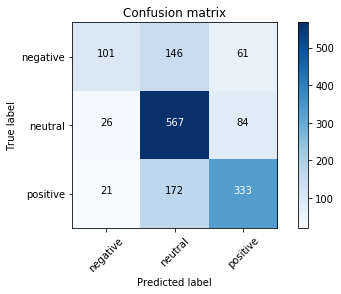

In [55]:
plot_confusion_matrix(cm, labels)

In [56]:
CONFUSION[1], F_SCORE[1]

(array([[101, 146,  61],
        [ 26, 567,  84],
        [ 21, 172, 333]]), 0.6464961708749172)

#### Quick test cases

In [57]:
pipelines[1].predict(['it was okay but it lacked emotion'])

array(['positive'], dtype=object)

In [58]:
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [59]:
mark_negation("I don't like the movie .".split())

['I', "don't", 'like_NEG', 'the_NEG', 'movie_NEG', '.']

#### Alternative Vectorization (pre-trained word vectors) - NOT TO BE USED

In [447]:
from gensim.models.word2vec import Word2Vec 
from gensim.models.doc2vec import TaggedDocument

In [448]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

In [449]:
def labelizeTweets(tweets, label_type):
    labelized = []
    for i,v in tqdm(enumerate(tweets)):
        label = '%s_%s'%(label_type,i)
        labelized.append(TaggedDocument(v, [label]))
    return labelized

In [450]:
TRAIN_TOKENS = pd.Series(TRAIN_DF).apply(grouping)
DEV_TOKENS = pd.Series(DEV_DF).apply(grouping)

In [451]:
x_train = labelizeTweets(TRAIN_TOKENS, 'TRAIN')
x_test = labelizeTweets(DEV_TOKENS, 'TEST')


0it [00:00, ?it/s]
8839it [00:00, 377460.88it/s]
0it [00:00, ?it/s]
1511it [00:00, 260153.25it/s]

In [452]:
x_train[0]

TaggedDocument(words=['gas', 'by', 'my', 'house', 'hit', '3', '39', '__punc_excl', 'i', 'be', 'go', 'to', 'chapel', 'hill', 'on', 'sit', '__emot_smiley'], tags=['TRAIN_0'])

In [453]:
tweet_w2v = Word2Vec(size=200, min_count=10)
tweet_w2v.build_vocab([x.words for x in tqdm(x_train)])
tweet_w2v.train([x.words for x in tqdm(x_train)], total_examples=len(x_train), epochs=10)


100%|██████████| 8839/8839 [00:00<00:00, 432711.85it/s]

1101750

In [468]:
tweet_w2v.wv.most_similar('time')

[('year', 0.8586527705192566),
 ('best', 0.8182728290557861),
 ('first', 0.8166179656982422),
 ('1st', 0.8146964311599731),
 ('one', 0.8102284073829651),
 ('2nd', 0.8052255511283875),
 ('half', 0.786620020866394),
 ('3rd', 0.7859094142913818),
 ('end', 0.7806460857391357),
 ('5th', 0.7793829441070557)]

In [455]:
# importing bokeh library for interactive dataviz
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

# defining the chart
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="A map of 10000 word vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

# getting a list of word vectors. limit to 10000. each is of 200 dimensions
word_vectors = [tweet_w2v.wv[w] for w in list(tweet_w2v.wv.vocab.keys())[:5000]]

# dimensionality reduction. converting the vectors to 2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = list(tweet_w2v.wv.vocab.keys())[:5000]

# plotting. the corresponding word appears when you hover on the data point.
plot_tfidf.scatter(x='x', y='y', source=tsne_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_tfidf)


Loading BokehJS ...

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2123 samples in 0.008s...
[t-SNE] Computed neighbors for 2123 samples in 1.722s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2123
[t-SNE] Computed conditional probabilities for sample 2000 / 2123
[t-SNE] Computed conditional probabilities for sample 2123 / 2123
[t-SNE] Mean sigma: 0.107869
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.907883
[t-SNE] Error after 1000 iterations: 1.131708


In [456]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += tweet_w2v[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [458]:
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x.words for x in x_train])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

In [459]:
from sklearn.preprocessing import scale
train_vecs_w2v = np.concatenate([buildWordVector(z, 200) for z in tqdm(map(lambda x: x.words, x_train))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, 200) for z in tqdm(map(lambda x: x.words, x_test))])
test_vecs_w2v = scale(test_vecs_w2v)



0it [00:00, ?it/s]/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


318it [00:00, 3122.79it/s]

597it [00:00, 2900.10it/s]

863it [00:00, 2849.05it/s]

1114it [00:00, 2767.68it/s]

1365it [00:00, 2720.44it/s]

1605it [00:00, 2662.05it/s]

1879it [00:00, 2672.31it/s]

2172it [00:00, 2703.48it/s]

2432it [00:00, 2692.64it/s]

2724it [00:01, 2707.54it/s]

3034it [00:01, 2730.52it/s]

3313it [00:01, 2742.68it/s]

3590it [00:01, 2739.33it/s]

3865it [00:01, 2707.50it/s]

4129it [00:01, 2680.82it/s]

4383it [00:01, 2654.20it/s]

4646it [00:01, 2651.44it/s]

4913it [00:01, 2652.35it/s]

5193it [00:01, 2658.91it/s]

5465it [00:02, 2662.35it/s]

5731it [00:02, 2649.14it/s]

5989it [00:02, 2635.98it/s]

6241it [00:02, 2624.40it/s]

6491it [00:02, 2614.63it/s]

6738it [00:02, 2595.59it/s]

6996it [00:02, 2597.79it/s]

7240it [00:02, 2589.46it/s]

7483it [

In [460]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [461]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils, to_categorical

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [462]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_Y)

In [463]:
train_vecs_w2v.shape

(8839, 200)

In [472]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=200))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_vecs_w2v, dummy_y_train, 
          validation_data=(test_vecs_w2v, dummy_y_test), epochs=9, batch_size=32, verbose=2, validation_split=0.0)

Train on 8839 samples, validate on 1511 samples
Epoch 1/9
 - 1s - loss: 0.9199 - acc: 0.5666 - val_loss: 0.9427 - val_acc: 0.5520
Epoch 2/9
 - 1s - loss: 0.8714 - acc: 0.5976 - val_loss: 0.9363 - val_acc: 0.5645
Epoch 3/9
 - 1s - loss: 0.8625 - acc: 0.6032 - val_loss: 0.9224 - val_acc: 0.5672
Epoch 4/9
 - 1s - loss: 0.8575 - acc: 0.6074 - val_loss: 0.9229 - val_acc: 0.5566
Epoch 5/9
 - 1s - loss: 0.8480 - acc: 0.6108 - val_loss: 0.9244 - val_acc: 0.5692
Epoch 6/9
 - 1s - loss: 0.8398 - acc: 0.6166 - val_loss: 0.9210 - val_acc: 0.5738
Epoch 7/9
 - 1s - loss: 0.8379 - acc: 0.6126 - val_loss: 0.9271 - val_acc: 0.5559
Epoch 8/9
 - 1s - loss: 0.8343 - acc: 0.6202 - val_loss: 0.9122 - val_acc: 0.5738
Epoch 9/9
 - 1s - loss: 0.8310 - acc: 0.6209 - val_loss: 0.9130 - val_acc: 0.5758


In [471]:
encoder.fit(DEV_DATA['label'])
encoded_Y = encoder.transform(DEV_DATA['label'])
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y)

In [129]:
score = model.evaluate(test_vecs_w2v, dummy_y_test, batch_size=32, verbose=2)
print (model.metrics_names[1], score[1])

acc 0.5857048292257863


In [ ]:
print("Dev accuracy" + str(np.sum(dev.iloc[:,0]==predicted)/len(predicted)*100 + "%")

In [ ]:
doc = ['I hate fucking cheese','I love cows']

In [ ]:
doc_tdf = tfidf_vectorizer.transform(doc)

In [ ]:
predicted = clf.predict(doc_tdf)

In [ ]:
for doc, category in zip(doc, predicted):
    print('%r => %s' % (doc, category))

In [ ]:
def flat_tokens(lol):
    return [lemmatizer.lemmatize(y.lower(),'v') for x in lol for y in x]

In [ ]:
pos_tokens = flat_tokens(pos_df['tweet'])

In [ ]:
neg_tokens = flat_tokens(neg_df['tweet'])

In [ ]:
tokens = flat_tokens(df['tweet'])

In [ ]:
tags = ['ADP','PRT','PRON','VERB','.']

In [ ]:
good_words = [w for w, wtype in tokens if wtype not in STOP_TYPES]

In [ ]:
nltk.pos_tag(nltk.word_tokenize('hello you'))[0][1]

In [ ]:
positive_words = Counter(pos_tokens)
negative_words = Counter(neg_tokens)
words = Counter(tokens)

In [ ]:
positive_words.most_common(10)

In [ ]:
pos_neg_ratios = Counter()

In [ ]:
for term,cnt in list(words.most_common()):
    if(cnt > 100):
        pos_neg_ratio = positive_words[term] / float(negative_words[term]+1)
        pos_neg_ratios[term] = pos_neg_ratio

In [ ]:
for word,ratio in pos_neg_ratios.most_common():
    if(ratio > 1):
        pos_neg_ratios[word] = np.log(ratio)
    else:
        pos_neg_ratios[word] = -np.log((1 / (ratio+0.01)))

In [ ]:
pos_neg_ratios.most_common(10)

In [ ]:
from nltk.corpus import stopwords

In [ ]:
stop = set(stopwords.words('english'))

In [ ]:
stop

In [ ]:
#Plot bar with values from dict and label with keys
plt.figure(figsize=(15,10))
plt.bar(range(len(OrderedDict(words.most_common(50)))), 
        OrderedDict(words.most_common(50)).values(), align='center')
plt.xticks(range(len(OrderedDict(words.most_common(50)))), OrderedDict(words.most_common(50)).keys())

#Rotate labels by 90 degrees so you can see them
locs, labeling = plt.xticks()
plt.setp(labeling, rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.suptitle('Word Distribution', fontweight='bold', fontsize=14);